This document is a thorough overview of my process for building a predictive model for Kaggle's Titanic competition. I will provide all my essential steps in this model as well as the reasoning behind each decision I made. This model achieves a score of 82.78%, which is in the top 3% of all submissions at the time of this writing. This is a great introductory modeling exercise due to the simple nature of the data, yet there is still a lot to be gleaned from following a process that ultimately yields a high score. 

### The Problem

We are given information about a subset of the Titanic population and asked to build a predictive model that tells us whether or not a given passenger survived the shipwreck. We are given 10 basic explanatory variables, including passenger gender, age, and price of fare, among others. More details about the competition can be found on the Kaggle site, [here](https://www.kaggle.com/c/titanic). This is a classic binary classification problem, and we will be implementing a random forest classifer.

- [Exploratory Data Analysis](#eda)
- [Feature Engineering](#feat)
- [Hyperparameter Tuning](#hyper)
- [Model Estimation and Evaluation](#model)

### Exploratory Data Analysis<a name="eda"></a>

The goal of this section is to gain an understanding of our data in order to inform what we do in the feature engineering section.  

We begin our exploratory data analysis by loading our standard modules.

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

We then load the data, which we have downloaded from the Kaggle website ([here](https://www.kaggle.com/c/titanic/data) is a link to the data if you need it).

In [2]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))

First, let's take a look at the summary of all the data. Immediately, we note that `Age`, `Cabin`, and `Embarked` have nulls that we'll have to deal with. 

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


It appears that we can drop the `PassengerId` column, since it is merely an index. Note, however, that some people have reportedly improved their score with the `PassengerId` column. However, my cursory attempt to do so did not yield positive results, and moreover I would like to mimic a real-life scenario, where an index of a dataset generally has no correlation with the target variable.

In [6]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Survived

So we can see that 62% of the people in the training set died. This is slightly less than the estimated 67% that died in the actual shipwreck (1500/2224).

In [7]:
train['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64


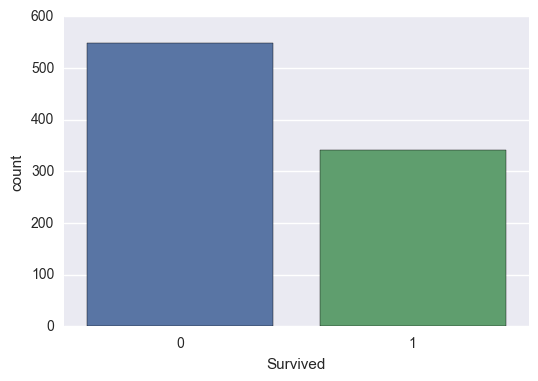

In [6]:
sns.countplot(train['Survived'])

## Pclass

Class played a critical role in survival, as the survival rate decreased drastically for the lowest class. This variable is both useful and clean, and I will be treating it as a categorical variable. 

In [8]:
train['Survived'].groupby(train['Pclass']).mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


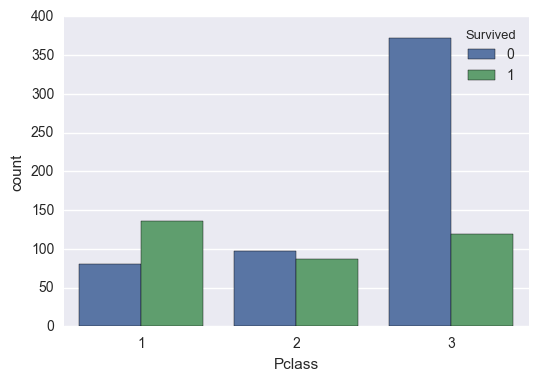

In [8]:
sns.countplot(train['Pclass'], hue=train['Survived'])

## Name  

The `Name` column as provided cannot be used in the model. However, we might be able to extract some meaningful information from it.

In [9]:
train['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

First, we can obtain useful information about the passenger's title. Looking at the distribution of the titles, it might be useful to group the smaller sized values into an 'other' group, although I ultimately choose not to do this.

In [10]:
train['Name_Title'] = train['Name'].apply(lambda x: x.split(',')[1]).apply(lambda x: x.split()[0])
train['Name_Title'].value_counts()

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Mlle.          2
Major.         2
Col.           2
Capt.          1
Sir.           1
the            1
Don.           1
Jonkheer.      1
Ms.            1
Mme.           1
Lady.          1
Name: Name_Title, dtype: int64

I have relatively high hopes for this new variable we created, since the survival rate appears to be either significantly above or below the average survival rate, which should help our model.

In [11]:
train['Survived'].groupby(train['Name_Title']).mean()

Name_Title
Capt.        0.000000
Col.         0.500000
Don.         0.000000
Dr.          0.428571
Jonkheer.    0.000000
Lady.        1.000000
Major.       0.500000
Master.      0.575000
Miss.        0.697802
Mlle.        1.000000
Mme.         1.000000
Mr.          0.156673
Mrs.         0.792000
Ms.          1.000000
Rev.         0.000000
Sir.         1.000000
the          1.000000
Name: Survived, dtype: float64

Additionally, looking at the relationship between the length of a name and survival rate appears to indicate that there is indeed a clear relationship. What might this mean? Are people with longer names more important, and thus more likely to be prioritized in a shipwreck? 

In [12]:
train['Name_Len'] = train['Name'].apply(lambda x: len(x))
train['Survived'].groupby(pd.qcut(train['Name_Len'],5)).mean()

Name_Len
[12, 19]    0.220588
(19, 23]    0.301282
(23, 27]    0.319797
(27, 32]    0.442424
(32, 82]    0.674556
Name: Survived, dtype: float64

In [13]:
pd.qcut(train['Name_Len'],5).value_counts()

[12, 19]    204
(23, 27]    197
(32, 82]    169
(27, 32]    165
(19, 23]    156
Name: Name_Len, dtype: int64

## Sex

"Women and children first," goes the famous saying. Thus, we should expect females to have a higher survival rate than males, and indeed that is the case. We expect this variable to be very useful in our model.

In [14]:
train['Sex'].value_counts(normalize=True)

male      0.647587
female    0.352413
Name: Sex, dtype: float64

In [15]:
train['Survived'].groupby(train['Sex']).mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

## Age

There are 177 nulls for `Age`, and they have a 10% lower survival rate than the non-nulls. Before imputing values for the nulls, we will include an `Age_null` flag just to make sure we can account for this characteristic of the data. 

In [16]:
train['Survived'].groupby(train['Age'].isnull()).mean()

Age
False    0.406162
True     0.293785
Name: Survived, dtype: float64

Upon first glance, the relationship between age and survival appears to be a murky one at best. However, this doesn't mean that the variable will be a bad predictor; at deeper levels of a given decision tree, a more discriminant relationship might open up.

In [17]:
train['Survived'].groupby(pd.qcut(train['Age'],5)).mean()

Age
[0.42, 19]    0.481707
(19, 25]      0.328467
(25, 31.8]    0.393701
(31.8, 41]    0.437500
(41, 80]      0.373239
Name: Survived, dtype: float64

In [18]:
pd.qcut(train['Age'],5).value_counts()

[0.42, 19]    164
(31.8, 41]    144
(41, 80]      142
(19, 25]      137
(25, 31.8]    127
Name: Age, dtype: int64

## SibSp  

Upon first glance, I'm not too convinced of the importance of this variable. The distribution and survival rate between the different categories does not give me much hope.

In [19]:
train['Survived'].groupby(train['SibSp']).mean()

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64

In [20]:
train['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

## Parch

Same conclusions as `Sibsp`: passengers with zero parents or children had a lower likelihood of survival than otherwise, but that survival rate was only slightly less than the overall population survival rate. 

In [21]:
train['Survived'].groupby(train['Parch']).mean()

Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64

In [22]:
train['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

When we have two seemingly weak predictors, one thing we can do is combine them to get a stronger predictor. In the case of `SibSp` and `Parch`, we can combine the two variables to get a 'family size' metric, which might (and in fact does) prove to be a better predictor than the two original variables. 

## Ticket  

The `Ticket` column seems to contain unique alphanumeric values, and is thus not very useful on its own. However, we might be able to extract come predictive power from it. 

In [23]:
train['Ticket'].head(n=10)

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
5              330877
6               17463
7              349909
8              347742
9              237736
Name: Ticket, dtype: object

One piece of potentially useful informatin is the number of characters in the `Ticket` column. This could be a reflection of the 'type' of ticket a given passenger had, which could somehow indicate their chances of survival. One theory (which may in fact be verifiable) is that some characteristic of the ticket could indicate the location of the passenger's room, which might be a crucial factor in their escape route, and consequently their survival.

In [24]:
train['Ticket_Len'] = train['Ticket'].apply(lambda x: len(x))

In [25]:
train.groupby(['Ticket_Len'])['Survived'].mean()

Ticket_Len
3     0.000000
4     0.366337
5     0.618321
6     0.319809
7     0.296296
8     0.539474
9     0.192308
10    0.341463
11    0.250000
12    0.400000
13    0.400000
15    0.333333
16    0.272727
17    0.428571
18    0.000000
Name: Survived, dtype: float64

In [26]:
train['Ticket_Len'].value_counts()

6     419
5     131
4     101
8      76
10     41
7      27
9      26
17     14
16     11
13     10
12     10
15      9
11      8
18      6
3       2
Name: Ticket_Len, dtype: int64

Another piece of information is the first letter of each ticket, which, again, might be indicative of a certain attribute of the ticketholders or their rooms.

In [27]:
train['Ticket_Lett'] = train['Ticket'].apply(lambda x: str(x)[0])

In [28]:
train['Ticket_Lett'].value_counts()

3    301
2    183
1    146
S     65
P     65
C     47
A     29
W     13
4     10
7      9
F      7
6      6
L      4
5      3
8      2
9      1
Name: Ticket_Lett, dtype: int64

In [29]:
train.groupby(['Ticket_Lett'])['Survived'].mean()

Ticket_Lett
1    0.630137
2    0.464481
3    0.239203
4    0.200000
5    0.000000
6    0.166667
7    0.111111
8    0.000000
9    1.000000
A    0.068966
C    0.340426
F    0.571429
L    0.250000
P    0.646154
S    0.323077
W    0.153846
Name: Survived, dtype: float64

## Fare

There is a clear relationship between `Fare` and `Survived`, and I'm guessing that this relationship is similar to that of `Class` and `Survived`.

In [30]:
pd.qcut(train['Fare'], 3).value_counts()

[0, 8.662]       308
(26, 512.329]    295
(8.662, 26]      288
Name: Fare, dtype: int64

In [31]:
train['Survived'].groupby(pd.qcut(train['Fare'], 3)).mean()

Fare
[0, 8.662]       0.198052
(8.662, 26]      0.402778
(26, 512.329]    0.559322
Name: Survived, dtype: float64

Looking at the relationship between `Class` and `Fare`, we do indeed see a clear relationship. 

In [32]:
pd.crosstab(pd.qcut(train['Fare'], 5), columns=train['Pclass'])

Pclass,1,2,3
Fare,,,
"[0, 7.854]",6,6,167
"(7.854, 10.5]",0,24,160
"(10.5, 21.679]",0,80,92
"(21.679, 39.688]",64,64,52
"(39.688, 512.329]",146,10,20


## Cabin

This column has the most nulls (almost 700), but we can still extract information from it, like the first letter of each cabin, or the cabin number. The usefulness of this column might be similar to that of the `Ticket` variable.

#### Cabin Letter

We can see that most of the cabin letters are associated with a high survival rate, so this might very well be a useful variable. Because there aren't that many unique values, we won't do any grouping here, even if some of the values have a small count.

In [33]:
train['Cabin_Letter'] = train['Cabin'].apply(lambda x: str(x)[0])

In [34]:
train['Cabin_Letter'].value_counts()

n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin_Letter, dtype: int64

In [35]:
train['Survived'].groupby(train['Cabin_Letter']).mean()

Cabin_Letter
A    0.466667
B    0.744681
C    0.593220
D    0.757576
E    0.750000
F    0.615385
G    0.500000
T    0.000000
n    0.299854
Name: Survived, dtype: float64

#### Cabin Number

Upon first glance, this appears to be useless. Not only do we have ~700 nulls which will be difficult to impute, but the correlation with `Survived` is almost zero. However, the cabin numbers as a whole do seem to have a high surival rate compared to the population average, so we might want to keep this just in case for now.

In [36]:
train['Cabin_num'] = train['Cabin'].apply(lambda x: str(x).split(' ')[-1][1:])
train['Cabin_num'].replace('an', np.NaN, inplace = True)
train['Cabin_num'] = train['Cabin_num'].apply(lambda x: int(x) if not pd.isnull(x) and x <> '' else np.NaN)

In [37]:
pd.qcut(train['Cabin_num'],3).value_counts()

(65.667, 148]       67
[2, 28.667]         67
(28.667, 65.667]    66
Name: Cabin_num, dtype: int64

In [38]:
train['Survived'].groupby(pd.qcut(train['Cabin_num'], 3)).mean()

Cabin_num
[2, 28.667]         0.716418
(28.667, 65.667]    0.651515
(65.667, 148]       0.641791
Name: Survived, dtype: float64

In [39]:
train['Survived'].corr(train['Cabin_num'])

-0.063845959227893712

## Embarked

Looks like the Cherbourg people had a 20% higher survival rate than the other embarking locations. This is very likely due to the high presence of upper-class passengers from that location.

In [40]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [41]:
train['Embarked'].value_counts(normalize=True)

S    0.724409
C    0.188976
Q    0.086614
Name: Embarked, dtype: float64

In [42]:
train['Survived'].groupby(train['Embarked']).mean()

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

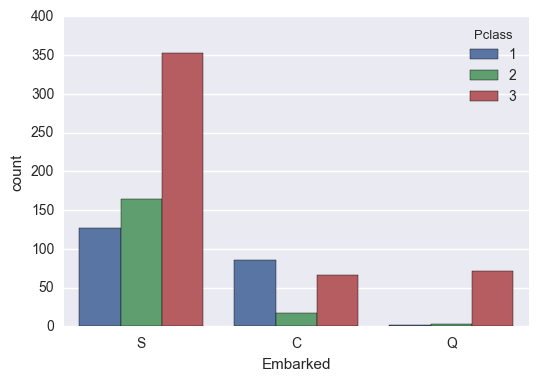

In [43]:
sns.countplot(train['Embarked'], hue=train['Pclass'])

### Feature Engineering<a name="feat"></a>

Having done our cursory exploration of the variables, we now have a pretty good idea of how we want to transform our variables in preparation for our final dataset. We will perform our feature engineering through a series of helper functions that each serve a specific purpose. 

This first function creates two separate columns: a numeric column indicating the length of a passenger's `Name` field, and a categorical column that extracts the passenger's title.

In [4]:
def names(train, test):
    for i in [train, test]:
        i['Name_Len'] = i['Name'].apply(lambda x: len(x))
        i['Name_Title'] = i['Name'].apply(lambda x: x.split(',')[1]).apply(lambda x: x.split()[0])
        del i['Name']
    return train, test

Next, we impute the null values of the `Age` column by filling in the mean value of the passenger's corresponding title and class. This more granular approach to imputation should be more accurate than merely taking the mean age of the population.

In [201]:
def age_impute(train, test):
    for i in [train, test]:
        i['Age_Null_Flag'] = i['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)
    train['mean'] = train.groupby(['Name_Title', 'Pclass'])['Age'].transform('mean')
    train['Age'] = train['Age'].fillna(train['mean'])
    z = test.merge(train, on=['Name_Title', 'Pclass'], how='left').drop_duplicates(['PassengerId_x'])
    test['Age'] = np.where(test['Age'].isnull(), z['mean'], test['Age'])
    test['Age'] = test['Age'].fillna(test['Age'].mean())
    del train['mean']
    return train, test

In [31]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))

In [32]:
train, test = names(train, test)

In [33]:
o = train.groupby(['Name_Title', 'Pclass'])['Age'].mean()
fill = pd.merge(test, pd.DataFrame(o), left_on=['Name_Title', 'Pclass'], right_index=True, how='left').iloc[:,-1]
 test['Age'].fillna(fill)

In [34]:
fill = pd.merge(test, pd.DataFrame(o), left_on=['Name_Title', 'Pclass'], right_index=True, how='left').iloc[:,-1]

In [35]:
 test['Age'].fillna(fill)

0      34.500000
1      47.000000
2      62.000000
3      27.000000
4      22.000000
5      14.000000
6      30.000000
7      26.000000
8      18.000000
9      21.000000
10     28.724891
11     46.000000
12     23.000000
13     63.000000
14     47.000000
15     24.000000
16     35.000000
17     21.000000
18     27.000000
19     45.000000
20     55.000000
21      9.000000
22     40.882353
23     21.000000
24     48.000000
25     50.000000
26     22.000000
27     22.500000
28     41.000000
29     28.724891
         ...    
388    21.000000
389     6.000000
390    23.000000
391    51.000000
392    13.000000
393    47.000000
394    29.000000
395    18.000000
396    24.000000
397    48.000000
398    22.000000
399    31.000000
400    30.000000
401    38.000000
402    22.000000
403    17.000000
404    43.000000
405    20.000000
406    23.000000
407    50.000000
408    16.123188
409     3.000000
410    16.123188
411    37.000000
412    28.000000
413    28.724891
414    39.000000
415    38.5000

We combine the `SibSp` and `Parch` columns into a new variable that indicates family size, and group the family size variable into three categories.

In [4]:
def fam_size(train, test):
    for i in [train, test]:
        i['Fam_Size'] = np.where((i['SibSp']+i['Parch']) == 0 , 'Solo',
                           np.where((i['SibSp']+i['Parch']) <= 3,'Nuclear', 'Big'))
        del i['SibSp']
        del i['Parch']
    return train, test

The `Ticket` column is used to create two new columns: `Ticket_Lett`, which indicates the first letter of each ticket (with the smaller-n values being grouped based on survival rate); and `Ticket_Len`, which indicates the length of the `Ticket` field. 

In [5]:
def ticket_grouped(train, test):
    for i in [train, test]:
        i['Ticket_Lett'] = i['Ticket'].apply(lambda x: str(x)[0])
        i['Ticket_Lett'] = i['Ticket_Lett'].apply(lambda x: str(x))
        i['Ticket_Lett'] = np.where((i['Ticket_Lett']).isin(['1', '2', '3', 'S', 'P', 'C', 'A']), i['Ticket_Lett'],
                                   np.where((i['Ticket_Lett']).isin(['W', '4', '7', '6', 'L', '5', '8']),
                                            'Low_ticket', 'Other_ticket'))
        i['Ticket_Len'] = i['Ticket'].apply(lambda x: len(x))
        del i['Ticket']
    return train, test

The following two functions extract the first letter of the `Cabin` column and its number, respectively. 

In [6]:
def cabin(train, test):
    for i in [train, test]:
        i['Cabin_Letter'] = i['Cabin'].apply(lambda x: str(x)[0])
        del i['Cabin']
    return train, test

In [7]:
def cabin_num(train, test):
    for i in [train, test]:
        i['Cabin_num1'] = i['Cabin'].apply(lambda x: str(x).split(' ')[-1][1:])
        i['Cabin_num1'].replace('an', np.NaN, inplace = True)
        i['Cabin_num1'] = i['Cabin_num1'].apply(lambda x: int(x) if not pd.isnull(x) and x <> '' else np.NaN)
        i['Cabin_num'] = pd.qcut(train['Cabin_num1'],3)
    train = pd.concat((train, pd.get_dummies(train['Cabin_num'], prefix = 'Cabin_num')), axis = 1)
    test = pd.concat((test, pd.get_dummies(test['Cabin_num'], prefix = 'Cabin_num')), axis = 1)
    del train['Cabin_num']
    del test['Cabin_num']
    del train['Cabin_num1']
    del test['Cabin_num1']
    return train, test

We fill the null values in the `Embarked` column with the most commonly occuring value, which is 'S.'

In [8]:
def embarked_impute(train, test):
    for i in [train, test]:
        i['Embarked'] = i['Embarked'].fillna('S')
    return train, test

We also fill in the one missing value of `Fare` in our test set with the mean value of `Fare` from the training set (transformations of test set data must always be fit using training data).

In [11]:
test['Fare'].fillna(train['Fare'].mean(), inplace = True)

Next, because we are using scikit-learn, we must convert our categorical columns into dummy variables. The following function does this, and then it drops the original categorical columns. It also makes sure that each category is present in both the training and test datasets.

In [12]:
def dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked', 'Ticket_Lett', 'Cabin_Letter', 'Name_Title', 'Fam_Size']):
    for column in columns:
        train[column] = train[column].apply(lambda x: str(x))
        test[column] = test[column].apply(lambda x: str(x))
        good_cols = [column+'_'+i for i in train[column].unique() if i in test[column].unique()]
        train = pd.concat((train, pd.get_dummies(train[column], prefix = column)[good_cols]), axis = 1)
        test = pd.concat((test, pd.get_dummies(test[column], prefix = column)[good_cols]), axis = 1)
        del train[column]
        del test[column]
    return train, test

Our last helper function drops any columns that haven't already been dropped. In our case, we only need to drop the `PassengerId` column, which we have decided is not useful for our problem (by the way, I've confirmed this with a separate test). Note that dropping the `PassengerId` column here means that we'll have to load it later when creating our submission file.

In [13]:
def drop(train, test, bye = ['PassengerId']):
    for i in [train, test]:
        for z in bye:
            del i[z]
    return train, test

Having built our helper functions, we can now execute them in order to build our dataset that will be used in the model:

In [202]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))
train, test = names(train, test)
train, test = age_impute(train, test)
train, test = cabin_num(train, test)
train, test = cabin(train, test)
train, test = embarked_impute(train, test)
train, test = fam_size(train, test)
test['Fare'].fillna(train['Fare'].mean(), inplace = True)
train, test = ticket_grouped(train, test)
train, test = dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked', 'Ticket_Lett',
                                                                     'Cabin_Letter', 'Name_Title', 'Fam_Size'])
train, test = drop(train, test)

We can see that our final dataset has 45 columns, composed of our target column and 44 predictor variables. Although highly dimensional datasets can result in high variance, I think we should be fine here. 

In [203]:
len(train.columns)

45

### Hyperparameter Tuning<a name="hyper"></a>

We will use grid search to identify the optimal parameters of our random forest model. Because our training dataset is quite small, we can get away with testing a wider range of hyperparameter values. When I ran this on my 8 GB Windows machine, the process took less than ten minutes. 

In [66]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)

param_grid = { "criterion"   : ["gini", "entropy"],
             "min_samples_leaf" : [1, 5, 10],
             "min_samples_split" : [2, 4, 10, 12, 16],
             "n_estimators": [50, 100, 400, 700, 1000]}

gs = GridSearchCV(estimator=rf,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=3,
                  n_jobs=-1)

gs = gs.fit(train.iloc[:, 1:], train.iloc[:, 0])

Looking at the results of the grid search, we can see that our optimal parameter settings are not at the endpoints of our provided values, meaning that we do not have to test more values. What else can we say about our optimal values? The `min_samples_split` parameter is at 10, which should help mitigate overfitting to a certain degree. This is especially good because we have a relatively large number of estimators (700), which could potentially increase our generalization error.

In [67]:
print(gs.best_score_)
print(gs.best_params_)
#print(gs.cv_results_)

0.838383838384
{'min_samples_split': 10, 'n_estimators': 700, 'criterion': 'gini', 'min_samples_leaf': 1}


### Model Estimation and Evaluation<a name="model"></a>

We are now ready to fit our model using the optimal hyperparameters. The out-of-bag score can give us an unbiased estimate of the model accuracy, and we can see that the score is 82.94%, which is only a little higher than our final leaderboard score.

In [205]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(criterion='gini', 
                             n_estimators=700,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)
rf.fit(train.iloc[:, 1:], train.iloc[:, 0])
print "%.4f" % rf.oob_score_ 

0.8294


Let's take a brief look at our variable importance according to our random forest model. We can see that some of the original columns we predicted would be important in fact were, including gender, fare, and age. But we also see title, name length, and ticket length feature prominently, so we can pat ourselves on the back for creating such useful variables.

In [18]:
pd.concat((pd.DataFrame(train.iloc[:, 1:].columns, columns = ['variable']), 
           pd.DataFrame(rf.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]

,variable,importance
12,Sex_female,0.111215
11,Sex_male,0.109769
33,Name_Title_Mr.,0.109746
1,Fare,0.088209
2,Name_Len,0.087904
0,Age,0.078651
8,Pclass_3,0.043268
35,Name_Title_Miss.,0.031292
7,Ticket_Len,0.031079
34,Name_Title_Mrs.,0.028852


Our last step is to predict the target variable for our test data and generate an output file that will be submitted to Kaggle. 

In [194]:
np.shape(test)

(418, 44)

In [206]:
predictions = rf.predict(test)
predictions = pd.DataFrame(predictions, columns=['Survived'])
test = pd.read_csv(os.path.join('data', 'test.csv'))
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv(os.path.join('submission_files', 'y_test17.csv'), sep=",", index = False)

## Conclusion

This exercise is a good example of how far basic feature engineering can take you. It is worth mentioning that I did try various other models before arriving at this one. Some of the other variations I tried were different groupings for the categorical variables (plenty more combinations remain), linear discriminant analysis on a couple numeric columns, and eliminating more variables, among other things. This is a competition with a generous allotment of submission attempts, and as a result, it's quite possible that even the leaderboard score is an overestimation of the true quality of the model, since the leaderboard can act as more of a validation score instead of a true test score. 

I welcome any comments and suggestions.